In [56]:
import torch
from torch import nn
from torchinfo import summary
import numpy as np

from tqdm import tqdm, trange

import torch
import torch.nn as nn
from torch.optim import Adam
from torch.nn import CrossEntropyLoss
from torch.utils.data import DataLoader

from torchvision.transforms import ToTensor
from torchvision.datasets.mnist import MNIST

np.random.seed(0)
torch.manual_seed(0)

In [36]:
import os
import torch
from torchvision import transforms, datasets
from torch.utils.data import DataLoader, Dataset
import matplotlib.pyplot as plt
from PIL import Image

class ADNIDataset(Dataset):
    def __init__(self, root_dir, transform=None):
        self.root_dir = root_dir
        self.transform = transform

        # Get a list of subdirectories (labels) in the root directory
        self.labels = sorted(os.listdir(root_dir))

        # Create a mapping from label (subdirectory) to an integer
        self.label_to_idx = {label: idx for idx, label in enumerate(self.labels)}

        self.data = []
        self.targets = []
        self.names = []

        # Create a dictionary to store the count of images for each class
        self.class_counts = {label: 0 for label in self.labels}

        # Iterate through subdirectories
        for label in self.labels:
            label_dir = os.path.join(root_dir, label)
            
            # Check if it's a directory
            if not os.path.isdir(label_dir):
                continue

            # Get a list of image files in the subdirectory
            image_files = [f for f in os.listdir(label_dir) if f.lower().endswith((".jpg", ".jpeg", ".png", ".gif"))]

            # Update class counts and append image paths and their corresponding labels
            for image_file in image_files:
                image_path = os.path.join(label_dir, image_file)
                self.data.append(image_path)
                self.targets.append(self.label_to_idx[label])
                self.names.append(image_file)
                self.class_counts[label] += 1

    def __len__(self):
        return len(self.data)

    def __getitem__(self, idx):
        image_path = self.data[idx]
        image = Image.open(image_path).convert('RGB')

        if self.transform:
            image = self.transform(image)

        label = self.targets[idx]
        name = self.names[idx]

        return image, label, name

    def get_class_counts(self):
        return self.class_counts
    
    def get_labels(self):
        return self.labels
    
    def get_names(self):
        return self.names

def create_dataloaders(dir, batch_size=64, shuffle=True, transform=None, num_workers=4):
    train_path = os.path.join(dir, "train")
    test_path = os.path.join(dir, "test")

    train_dataset = ADNIDataset(train_path, transform=transform)
    test_dataset = ADNIDataset(test_path, transform=transform)

    train_loader = DataLoader(train_dataset, batch_size=64, shuffle=False)
    test_loader = DataLoader(test_dataset, batch_size=64, shuffle=False)

    return train_loader, test_loader

In [37]:
transform = transforms.Compose([
    transforms.Resize((224, 224)),
    # transforms.RandomRotation(degrees=90),
    transforms.ToTensor(),
])

train_loader, test_loader = create_dataloaders("D:/AD_NC", transform=transform)
print(train_loader.dataset.get_class_counts())
print(test_loader.dataset.get_class_counts())

{'AD': 10400, 'NC': 11120}
{'AD': 4460, 'NC': 4540}


In [42]:
PATCH_SIZE = 16
IMAGE_WIDTH = 224
IMAGE_HEIGHT = IMAGE_WIDTH
IMAGE_CHANNELS = 3
EMBEDDING_DIMS = IMAGE_CHANNELS * PATCH_SIZE**2
NUM_OF_PATCHES = int((IMAGE_WIDTH * IMAGE_HEIGHT) / PATCH_SIZE**2)

#the image width and image height should be divisible by patch size. This is a check to see that.

assert IMAGE_WIDTH % PATCH_SIZE == 0 and IMAGE_HEIGHT % PATCH_SIZE ==0 , print("Image Width is not divisible by patch size")

In [25]:
conv_layer = nn.Conv2d(in_channels = IMAGE_CHANNELS, out_channels = EMBEDDING_DIMS, kernel_size = PATCH_SIZE, stride = PATCH_SIZE)

64
(3, 224, 224)
218391_78.jpeg


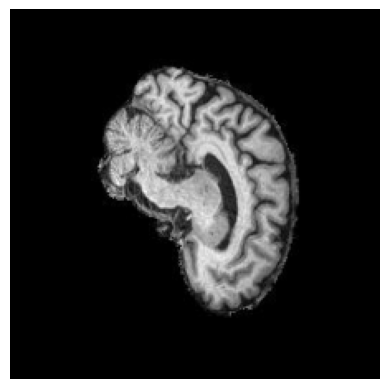

In [39]:
images, labels, names = next(iter(train_loader))
image = images[0]
imagesnp = images.numpy()
print(len(images))
print(imagesnp[0].shape)
print(names[0])
plt.imshow(imagesnp[0][0], cmap='gray')
plt.axis("off")
plt.show()

In [ ]:
# Pass the image through the convolution layer
image_through_conv = conv_layer(image.unsqueeze(0))
print(f'Shape of embeddings through the conv layer -> {list(image_through_conv.shape)} <- [batch_size, num_of_patch_rows,num_patch_cols embedding_dims]')

# Permute the dimensions of image_through_conv to match the expected shape
image_through_conv = image_through_conv.permute((0, 2, 3, 1))

# Create a flatten layer using nn.Flatten
flatten_layer = nn.Flatten(start_dim=1, end_dim=2)

# Pass the image_through_conv through the flatten layer
image_through_conv_and_flatten = flatten_layer(image_through_conv)

# Print the shape of the embedded image
print(f'Shape of embeddings through the flatten layer -> {list(image_through_conv_and_flatten.shape)} <- [batch_size, num_of_patches, embedding_dims]')

# Assign the embedded image to a variable
embedded_image = image_through_conv_and_flatten

In [ ]:
class_token_embeddings = nn.Parameter(torch.rand((1, 1,EMBEDDING_DIMS), requires_grad  = True))
print(f'Shape of class_token_embeddings --> {list(class_token_embeddings.shape)} <-- [batch_size, 1, emdedding_dims]')

embedded_image_with_class_token_embeddings = torch.cat((class_token_embeddings, embedded_image), dim = 1)
print(f'\nShape of image embeddings with class_token_embeddings --> {list(embedded_image_with_class_token_embeddings.shape)} <-- [batch_size, num_of_patches+1, embeddiing_dims]')

position_embeddings = nn.Parameter(torch.rand((1, NUM_OF_PATCHES+1, EMBEDDING_DIMS ), requires_grad = True ))
print(f'\nShape of position_embeddings --> {list(position_embeddings.shape)} <-- [batch_size, num_patches+1, embeddings_dims]')

final_embeddings = embedded_image_with_class_token_embeddings + position_embeddings
print(f'\nShape of final_embeddings --> {list(final_embeddings.shape)} <-- [batch_size, num_patches+1, embeddings_dims]')

In [43]:
BATCH_SIZE = 64

class PatchEmbeddingLayer(nn.Module):
    def __init__(self, in_channels, patch_size, embedding_dim,):
        super().__init__()
        self.patch_size = patch_size
        self.embedding_dim = embedding_dim
        self.in_channels = in_channels
        self.conv_layer = nn.Conv2d(in_channels=in_channels, out_channels=embedding_dim, kernel_size=patch_size, stride=patch_size)
        self.flatten_layer = nn.Flatten(start_dim=1, end_dim=2)
        self.class_token_embeddings = nn.Parameter(torch.rand((BATCH_SIZE, 1, EMBEDDING_DIMS), requires_grad=True))
        self.position_embeddings = nn.Parameter(torch.rand((1, NUM_OF_PATCHES + 1, EMBEDDING_DIMS), requires_grad=True))

    def forward(self, x):
        output = torch.cat((self.class_token_embeddings, self.flatten_layer(self.conv_layer(x).permute((0, 2, 3, 1)))), dim=1) + self.position_embeddings
        return output

In [44]:
patch_embedding_layer = PatchEmbeddingLayer(in_channels=IMAGE_CHANNELS, patch_size=PATCH_SIZE, embedding_dim=IMAGE_CHANNELS * PATCH_SIZE ** 2)
patch_embeddings = patch_embedding_layer(images)
patch_embeddings.shape

torch.Size([64, 197, 768])

In [30]:
summary(model=patch_embedding_layer,
        input_size=(BATCH_SIZE, 1, 224, 224), # (batch_size, input_channels, img_width, img_height)
        col_names=["input_size", "output_size", "num_params", "trainable"],
        col_width=20,
        row_settings=["var_names"])

Layer (type (var_name))                       Input Shape          Output Shape         Param #              Trainable
PatchEmbeddingLayer (PatchEmbeddingLayer)     [64, 1, 224, 224]    [64, 197, 256]       66,816               True
├─Conv2d (conv_layer)                         [64, 1, 224, 224]    [64, 256, 14, 14]    65,792               True
├─Flatten (flatten_layer)                     [64, 14, 14, 256]    [64, 196, 256]       --                   --
Total params: 132,608
Trainable params: 132,608
Non-trainable params: 0
Total mult-adds (Units.MEGABYTES): 825.29
Input size (MB): 12.85
Forward/backward pass size (MB): 25.69
Params size (MB): 0.26
Estimated Total Size (MB): 38.80

In [45]:
class MSABlock(nn.Module):
  def __init__(self,
            embedding_dims = 768, # Hidden Size D in the ViT Paper Table 1
            num_heads = 12,  # Heads in the ViT Paper Table 1
            attn_dropout = 0.0 # Default to Zero as there is no dropout for the the MSA Block as per the ViT Paper
            ):
    super().__init__()

    self.embedding_dims = embedding_dims
    self.num_head = num_heads
    self.attn_dropout = attn_dropout

    self.layernorm = nn.LayerNorm(normalized_shape = embedding_dims)

    self.multiheadattention =  nn.MultiheadAttention(num_heads = num_heads,
                                                    embed_dim = embedding_dims,
                                                    dropout = attn_dropout,
                                                    batch_first = True,
                                                    )

  def forward(self, x):
    x = self.layernorm(x)
    output,_ = self.multiheadattention(query=x, key=x, value=x,need_weights=False)
    return output

In [46]:
msa_block = MSABlock(embedding_dims = EMBEDDING_DIMS,
                    num_heads = 12
                    )
print(f'Shape of the input Patch Embeddings => {list(patch_embeddings.shape)} <= [batch_size, num_patches+1, embedding_dims ]')
print(f'Shape of the output from MSA Block => {list(msa_block(patch_embeddings).shape)} <= [batch_size, num_patches+1, embedding_dims ]')

Shape of the input Patch Embeddings => [64, 197, 768] <= [batch_size, num_patches+1, embedding_dims ]
Shape of the output from MSA Block => [64, 197, 768] <= [batch_size, num_patches+1, embedding_dims ]


In [47]:
summary(model=msa_block,
        input_size=(1, 197, 768), # (batch_size, num_patches, embedding_dimension)
        col_names=["input_size", "output_size", "num_params", "trainable"],
        col_width=20,
        row_settings=["var_names"])

Layer (type (var_name))                       Input Shape          Output Shape         Param #              Trainable
MSABlock (MSABlock)                           [1, 197, 768]        [1, 197, 768]        --                   True
├─LayerNorm (layernorm)                       [1, 197, 768]        [1, 197, 768]        1,536                True
├─MultiheadAttention (multiheadattention)     --                   [1, 197, 768]        2,362,368            True
Total params: 2,363,904
Trainable params: 2,363,904
Non-trainable params: 0
Total mult-adds (Units.MEGABYTES): 0.00
Input size (MB): 0.61
Forward/backward pass size (MB): 1.21
Params size (MB): 0.01
Estimated Total Size (MB): 1.82

In [48]:
class MLPBlock(nn.Module):
  def __init__(self, embedding_dims, mlp_size, mlp_dropout):
    super().__init__()
    self.embedding_dims = embedding_dims
    self.mlp_size = mlp_size
    self.dropout = mlp_dropout

    self.layernorm = nn.LayerNorm(normalized_shape = embedding_dims)
    self.mlp = nn.Sequential(
        nn.Linear(in_features = embedding_dims, out_features = mlp_size),
        nn.GELU(),
        nn.Dropout(p = mlp_dropout),
        nn.Linear(in_features = mlp_size, out_features = embedding_dims),
        nn.Dropout(p = mlp_dropout)
    )

  def forward(self, x):
    return self.mlp(self.layernorm(x))

In [49]:
mlp_block = MLPBlock(embedding_dims = EMBEDDING_DIMS,
                    mlp_size = 3072,
                    mlp_dropout = 0.1)

summary(model=mlp_block,
        input_size=(1, 197, 768), # (batch_size, num_patches, embedding_dimension)
        col_names=["input_size", "output_size", "num_params", "trainable"],
        col_width=20,
        row_settings=["var_names"])

Layer (type (var_name))                  Input Shape          Output Shape         Param #              Trainable
MLPBlock (MLPBlock)                      [1, 197, 768]        [1, 197, 768]        --                   True
├─LayerNorm (layernorm)                  [1, 197, 768]        [1, 197, 768]        1,536                True
├─Sequential (mlp)                       [1, 197, 768]        [1, 197, 768]        --                   True
│    └─Linear (0)                        [1, 197, 768]        [1, 197, 3072]       2,362,368            True
│    └─GELU (1)                          [1, 197, 3072]       [1, 197, 3072]       --                   --
│    └─Dropout (2)                       [1, 197, 3072]       [1, 197, 3072]       --                   --
│    └─Linear (3)                        [1, 197, 3072]       [1, 197, 768]        2,360,064            True
│    └─Dropout (4)                       [1, 197, 768]        [1, 197, 768]        --                   --
Total params: 4,723,

In [50]:
class TransformerBlock(nn.Module):
    def __init__(self, embedding_dims = 768,
                mlp_dropout=0.1,
                attn_dropout=0.0,
                mlp_size = 3072,
                num_heads = 12,
                ):
        super().__init__()

        self.msa_block = MSABlock(embedding_dims = embedding_dims,
                                                    num_heads = num_heads,
                                                    attn_dropout = attn_dropout)

        self.mlp_block = MLPBlock(embedding_dims = embedding_dims,
                                                        mlp_size = mlp_size,
                                                        mlp_dropout = mlp_dropout,
                                                        )

    def forward(self,x):
        x = self.msa_block(x) + x
        x = self.mlp_block(x) + x

        return x

In [51]:
transformer_block = TransformerBlock(embedding_dims = EMBEDDING_DIMS,
                                    mlp_dropout = 0.1,
                                    attn_dropout=0.0,
                                    mlp_size = 3072,
                                    num_heads = 12)

print(f'Shape of the input Patch Embeddings => {list(patch_embeddings.shape)} <= [batch_size, num_patches+1, embedding_dims ]')
print(f'Shape of the output from Transformer Block => {list(transformer_block(patch_embeddings).shape)} <= [batch_size, num_patches+1, embedding_dims ]')

Shape of the input Patch Embeddings => [64, 197, 768] <= [batch_size, num_patches+1, embedding_dims ]
Shape of the output from Transformer Block => [64, 197, 768] <= [batch_size, num_patches+1, embedding_dims ]


In [52]:
summary(model=transformer_block,
        input_size=(1, 197, 768), # (batch_size, num_patches, embedding_dimension)
        col_names=["input_size", "output_size", "num_params", "trainable"],
        col_width=20,
        row_settings=["var_names"])

Layer (type (var_name))                            Input Shape          Output Shape         Param #              Trainable
TransformerBlock (TransformerBlock)                [1, 197, 768]        [1, 197, 768]        --                   True
├─MSABlock (msa_block)                             [1, 197, 768]        [1, 197, 768]        --                   True
│    └─LayerNorm (layernorm)                       [1, 197, 768]        [1, 197, 768]        1,536                True
│    └─MultiheadAttention (multiheadattention)     --                   [1, 197, 768]        2,362,368            True
├─MLPBlock (mlp_block)                             [1, 197, 768]        [1, 197, 768]        --                   True
│    └─LayerNorm (layernorm)                       [1, 197, 768]        [1, 197, 768]        1,536                True
│    └─Sequential (mlp)                            [1, 197, 768]        [1, 197, 768]        --                   True
│    │    └─Linear (0)                     

In [53]:
class ViT(nn.Module):
    def __init__(self, img_size = 224,
                in_channels = 3,
                patch_size = 16,
                embedding_dims = 768,
                num_transformer_layers = 12, # from table 1 above
                mlp_dropout = 0.1,
                attn_dropout = 0.0,
                mlp_size = 3072,
                num_heads = 12,
                num_classes = 1000):
        super().__init__()

        self.patch_embedding_layer = PatchEmbeddingLayer(in_channels = in_channels,
                                                        patch_size=patch_size,
                                                        embedding_dim = embedding_dims)

        self.transformer_encoder = nn.Sequential(*[TransformerBlock(embedding_dims = embedding_dims,
                                                mlp_dropout = mlp_dropout,
                                                attn_dropout = attn_dropout,
                                                mlp_size = mlp_size,
                                                num_heads = num_heads) for _ in range(num_transformer_layers)])

        self.classifier = nn.Sequential(nn.LayerNorm(normalized_shape = embedding_dims),
                                        nn.Linear(in_features = embedding_dims,
                                                out_features = num_classes))

    def forward(self, x):
        return self.classifier(self.transformer_encoder(self.patch_embedding_layer(x))[:, 0])

In [58]:
model = ViT(img_size = 224,
        in_channels = 3,
        patch_size = 16,
        embedding_dims = EMBEDDING_DIMS,
        num_transformer_layers = 12, # from table 1 above
        mlp_dropout = 0.1,
        attn_dropout = 0.0,
        mlp_size = 3072,
        num_heads = 12,
        num_classes = 2)

summary(model=model,
        input_size=(BATCH_SIZE, 3, 224, 224), # (batch_size, num_patches, embedding_dimension)
        col_names=["input_size", "output_size", "num_params", "trainable"],
        col_width=20,
        row_settings=["var_names"])

Layer (type (var_name))                                      Input Shape          Output Shape         Param #              Trainable
ViT (ViT)                                                    [64, 3, 224, 224]    [64, 2]              --                   True
├─PatchEmbeddingLayer (patch_embedding_layer)                [64, 3, 224, 224]    [64, 197, 768]       200,448              True
│    └─Conv2d (conv_layer)                                   [64, 3, 224, 224]    [64, 768, 14, 14]    590,592              True
│    └─Flatten (flatten_layer)                               [64, 14, 14, 768]    [64, 196, 768]       --                   --
├─Sequential (transformer_encoder)                           [64, 197, 768]       [64, 197, 768]       --                   True
│    └─TransformerBlock (0)                                  [64, 197, 768]       [64, 197, 768]       --                   True
│    │    └─MSABlock (msa_block)                             [64, 197, 768]       [64, 197, 76

In [59]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print("Using device: ", device, f"({torch.cuda.get_device_name(device)})" if torch.cuda.is_available() else "")
N_EPOCHS = 5
LR = 0.005
optimizer = Adam(model.parameters(), lr=LR)
criterion = CrossEntropyLoss()

Using device:  cuda (NVIDIA GeForce RTX 3060 Laptop GPU)


In [60]:
# Training loop
for epoch in trange(N_EPOCHS, desc="Training"):
    train_loss = 0.0
    for batch in tqdm(train_loader, desc=f"Epoch {epoch + 1} in training", leave=False):
        x, y, name = batch
        x, y = x.to(device), y.to(device)
        y_hat = model(x)
        loss = criterion(y_hat, y)

        train_loss += loss.detach().cpu().item() / len(train_loader)

        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

    print(f"Epoch {epoch + 1}/{N_EPOCHS} loss: {train_loss:.2f}")

Training:   0%|          | 0/5 [11:34<?, ?it/s]


KeyboardInterrupt: 